# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import random
import itertools


from shutil import copyfile, rmtree
from pathlib import Path


from glob import glob

import os
# for dirname, _, filenames in os.walk('/kaggle/input/facial-age/face_age'):
#     print (dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

Python 3.7.10


## Visualization

In [2]:
# Directory containing the age classes
#INPUT_CLASSES_DIR = '/kaggle/input/facial-age/face_age/'
INPUT_CLASSES_DIR = '/kaggle/input/face-age-w-asian/face_age/'

# List of folders in the specified directory
folders = glob(INPUT_CLASSES_DIR + '*')

# Dictionary to store the number of files per age
ages_dict = {}

# Iterate through the folders and count the files in each folder
for dirname in folders:
    age = dirname.rsplit('/')[-1]
    if age != 'face_age':
        ages_dict[age] = len(os.listdir(dirname))

# Sort the ages
ages_dict = dict(sorted(ages_dict.items()))

# Display the possible ages
print('Possible ages:')
for age in ages_dict.keys():
    print(age)

Possible ages:
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
082
083
084
085
086
087
088
089
090
091
092
093
095
096
099
100
101
110


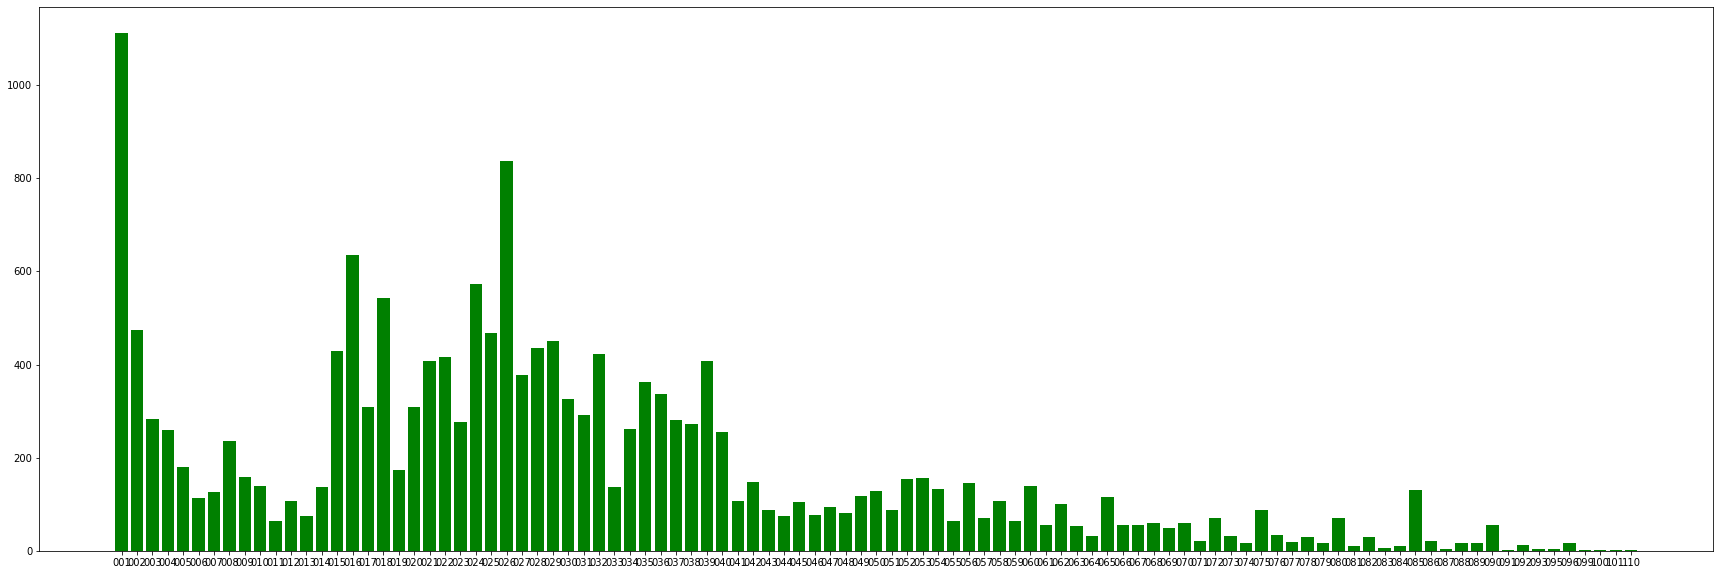

In [3]:
plt.figure(figsize=(30, 10))

plt.bar(list(ages_dict.keys()), ages_dict.values(), color='g')

plt.show()


## Preprocessing

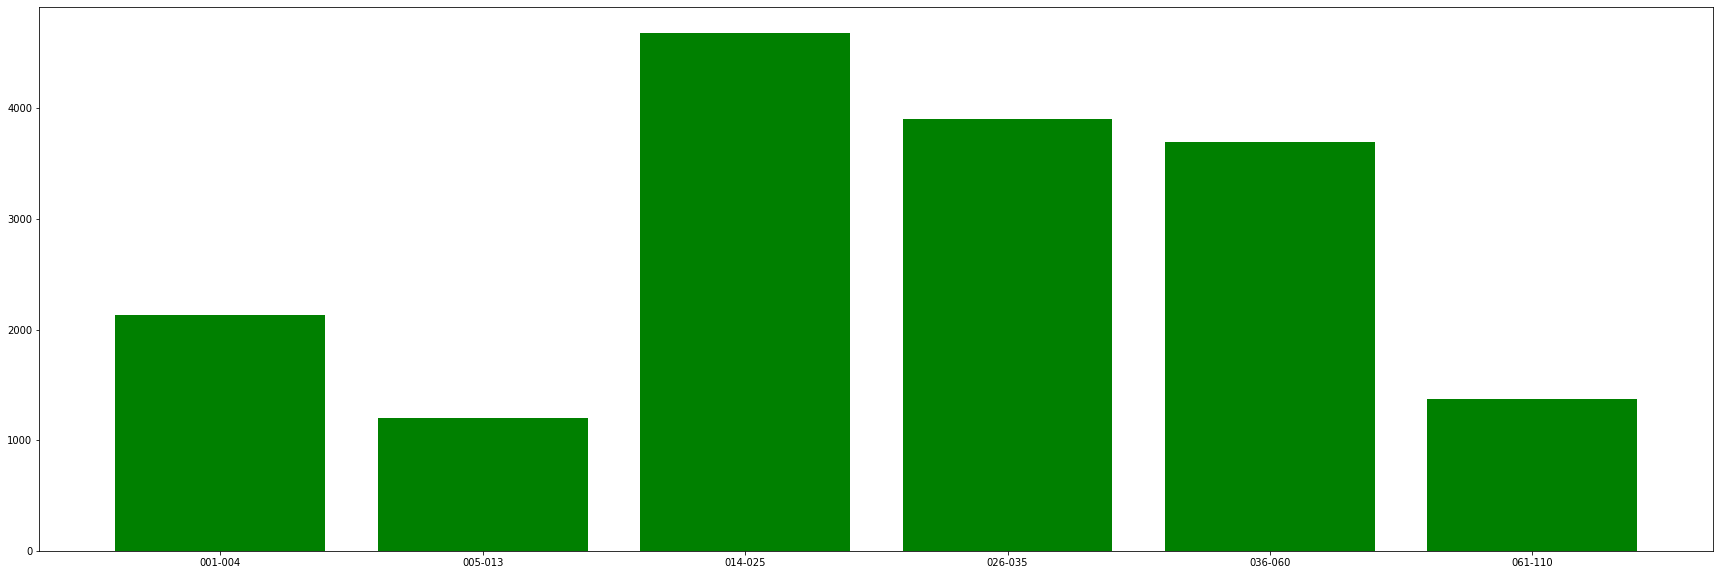

In [4]:
age_splits = [1,5,14,26,36,61,111]

age_splits_ranges = [[str(x).rjust(3,"0") for x in list(range(age_splits[idx],age_splits[idx+1]))] for idx in range(len(age_splits)-1)]

age_groups = {}

for age_range in age_splits_ranges:
    total = 0
    for age in age_range:
        if age in ages_dict:
            total += ages_dict[age]
    age_groups[f'{age_range[0]}-{age_range[-1]}'] = total
    
#age_groups
plt.figure(figsize=(30, 10))

plt.bar(list(age_groups.keys()), age_groups.values(), color='g')

plt.show()


In [5]:
age_groups

{'001-004': 2131,
 '005-013': 1199,
 '014-025': 4679,
 '026-035': 3902,
 '036-060': 3697,
 '061-110': 1375}

In [6]:
for val in age_groups.values():
    print(val)

2131
1199
4679
3902
3697
1375


In [7]:
train_sample_size = []
for val in age_groups.values():
    train_sample_size.append(int(val * 0.8))

In [8]:
test_root = './test'
train_root = './train'

rmtree(train_root, ignore_errors=True)
rmtree(test_root, ignore_errors=True)

age_groupped_filenames_dict = {}

for age_range in age_splits_ranges:
    Path(f"{test_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    Path(f"{train_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    age_groupped_filenames = []
    for age in age_range:
        full_dirname = INPUT_CLASSES_DIR + age
        age_groupped_filenames.extend(glob(full_dirname + '/*'))
    age_groupped_filenames_dict[f'{age_range[0]}-{age_range[-1]}'] = age_groupped_filenames
    
i = 0  # Pour itérer à travers train_sample_size
for age_range in age_groupped_filenames_dict:
    print(age_range)
    # Utiliser la taille correspondante de train_sample_size
    current_train_sample_size = train_sample_size[i]
    i += 1
    age_sample = random.sample(age_groupped_filenames_dict[age_range], len(age_groupped_filenames_dict[age_range]))
        
    train_filenames = age_sample[:current_train_sample_size]
    for f in train_filenames:
        copyfile(f, f"{train_root}/{age_range}/{f.split('/')[-1]}")
        #print(f"{train_root}/{age_range}/{f.split('/')[-1]}")
    test_filenames = age_sample[current_train_sample_size:]
    for f in test_filenames:
        copyfile(f, f"{test_root}/{age_range}/{f.split('/')[-1]}")
        #print(f"{test_root}/{age_range}/{f.split('/')[-1]}")

001-004
005-013
014-025
026-035
036-060
061-110


In [9]:
# useful for getting number of files
train_files = glob(train_root + '/*/*.png')
test_files = glob(test_root + '/*/*.png')


In [10]:
print(len(train_files))
print(len(test_files))


13584
3399


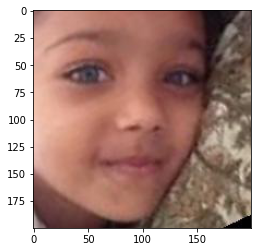

In [11]:
plt.imshow(image.load_img(np.random.choice(train_files)))

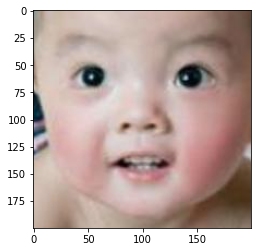

In [12]:
plt.imshow(image.load_img(np.random.choice(test_files)))


## Choose the LLM pretrained model here 

1. ResNet50
2. Xception
3. MobileNetV3
4. InceptionResNetV2

The choice of model has been made [here](https://keras.io/api/applications/#usage-examples-for-image-classification-models).

### 1. Resnet model

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [14]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [15]:
# training config:
epochs = 20
batch_size = 128

In [16]:
# resnet base
res = ResNet50(
input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
loss='sparse_categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

94781440/94765736 [==============================] - 0s 0us/step


### 2. Xception

In [15]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

In [16]:
IMAGE_SIZE = [299, 299]

In [17]:
# training config:
epochs = 20
batch_size = 128

In [18]:
# Xception base
xception = Xception(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False
)

# don't train existing weights
for layer in xception.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(xception.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=xception.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

83697664/83683744 [==============================] - 1s 0us/step


### 3. MobileNetV3

In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
# training config:
epochs = 20
batch_size = 128

In [ ]:
mobileNetV3Large = tf.keras.applications.MobileNetV3Large(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False
)

# don't train existing weights
for layer in mobileNetV3Large.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(mobileNetV3Large.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=mobileNetV3Large.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 4. InceptionResnetV2

In [71]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

In [72]:
IMAGE_SIZE = [299, 299]

In [73]:
# training config:
epochs = 20
batch_size = 128

In [74]:
inceptionResNetV2 = tf.keras.applications.InceptionResNetV2(
    input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False
)

# don't train existing weights
for layer in inceptionResNetV2.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(inceptionResNetV2.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inceptionResNetV2.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

219070464/219055592 [==============================] - 1s 0us/step


## Rest of code for each model

### Creating and Configuring Image Data Generators

In [18]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [19]:
# get label mapping for confusion matrix plot
test_gen = val_gen.flow_from_directory(test_root, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 3399 images belonging to 6 classes.
{'001-004': 0, '005-013': 1, '014-025': 2, '026-035': 3, '036-060': 4, '061-110': 5}


In [20]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_root,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  test_root,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 13584 images belonging to 6 classes.
Found 3399 images belonging to 6 classes.


### Fit/train the model

In [21]:
"""
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(train_files) // batch_size,
    validation_steps=len(test_files) // batch_size,
    callbacks=[early_stopping]
)
"""

history = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(test_files) // batch_size,
)

Epoch 1/20
106/106 [==============================] - 192s 2s/step - loss: 5.3421 - accuracy: 0.4495 - val_loss: 3.2003 - val_accuracy: 0.5358
Epoch 2/20
106/106 [==============================] - 183s 2s/step - loss: 4.8316 - accuracy: 0.5045 - val_loss: 4.3747 - val_accuracy: 0.5291
Epoch 3/20
106/106 [==============================] - 183s 2s/step - loss: 5.4373 - accuracy: 0.5124 - val_loss: 5.7948 - val_accuracy: 0.5418
Epoch 4/20
106/106 [==============================] - 182s 2s/step - loss: 5.6101 - accuracy: 0.5265 - val_loss: 4.6900 - val_accuracy: 0.5195
Epoch 5/20
106/106 [==============================] - 182s 2s/step - loss: 5.1315 - accuracy: 0.5478 - val_loss: 4.5653 - val_accuracy: 0.5394
Epoch 6/20
106/106 [==============================] - 182s 2s/step - loss: 5.6734 - accuracy: 0.5447 - val_loss: 4.9043 - val_accuracy: 0.5703
Epoch 7/20
106/106 [==============================] - 183s 2s/step - loss: 5.8504 - accuracy: 0.5535 - val_loss: 5.5398 - val_accuracy: 0.5394

## Add history

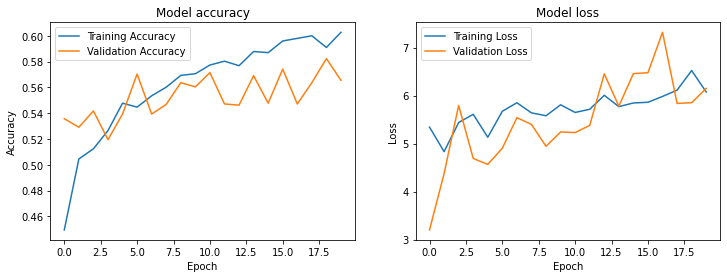

In [22]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.show()

# Plot the training history
plot_training_history(history)


## Save model

In [ ]:
model.save('age_resnet_final.h5')

## Load Pretrained Model (Only If You Have an .h5 File)

In [30]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('/kaggle/input/h5file/age_Xception.h5')

## Model Evaluation: Predictions, Mean Squared Error, and Confusion Matrix

### Mean Squared Error

In [24]:
from sklearn.metrics import mean_squared_error


# Faire des prédictions sur les données de validation
y_pred = model.predict(valid_generator)
y_true = valid_generator.classes

# Calculer la MSE
mse = mean_squared_error(y_true, y_pred.argmax(axis=1))

print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.7166813768755517


### Loss And accuracy

In [26]:
test_loss, test_accuracy = model.evaluate(valid_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


27/27 [==============================] - 14s 506ms/step - loss: 6.1465 - accuracy: 0.5675
Test Loss: 6.146541118621826
Test Accuracy: 0.5675198435783386


### Confusion Matrix

In [27]:
def get_confusion_matrix(data_path, N):
    # Créer un générateur d'images pour les données de test
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = val_gen.flow_from_directory(
        data_path,
        target_size=IMAGE_SIZE,
        shuffle=False,
        batch_size=batch_size,
        class_mode='sparse'
    )
    
    # Prédire les étiquettes pour les données de test
    y_pred = model.predict(test_generator, steps=len(test_generator))
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Obtenir les étiquettes vraies
    y_true = test_generator.classes
    
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred_classes)
    return cm


In [28]:
cm = get_confusion_matrix(train_root, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(test_root, len(test_files))
print(valid_cm)

Found 13584 images belonging to 6 classes.
[[1472  188   22   15    2    5]
 [  32  720  117   71   14    5]
 [   2  113 2573  909  134   12]
 [   1   21  884 1816  382   17]
 [   2   16  428  721 1503  287]
 [   0    4   11   24   91  970]]
Found 3399 images belonging to 6 classes.
[[349  62   7   7   1   1]
 [ 10 155  42  25   3   5]
 [  1  37 558 290  46   4]
 [  1  16 274 347 135   8]
 [  0   5 105 222 301 107]
 [  0   1   4   7  44 219]]


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(30, 30))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[1472  188   22   15    2    5]
 [  32  720  117   71   14    5]
 [   2  113 2573  909  134   12]
 [   1   21  884 1816  382   17]
 [   2   16  428  721 1503  287]
 [   0    4   11   24   91  970]]


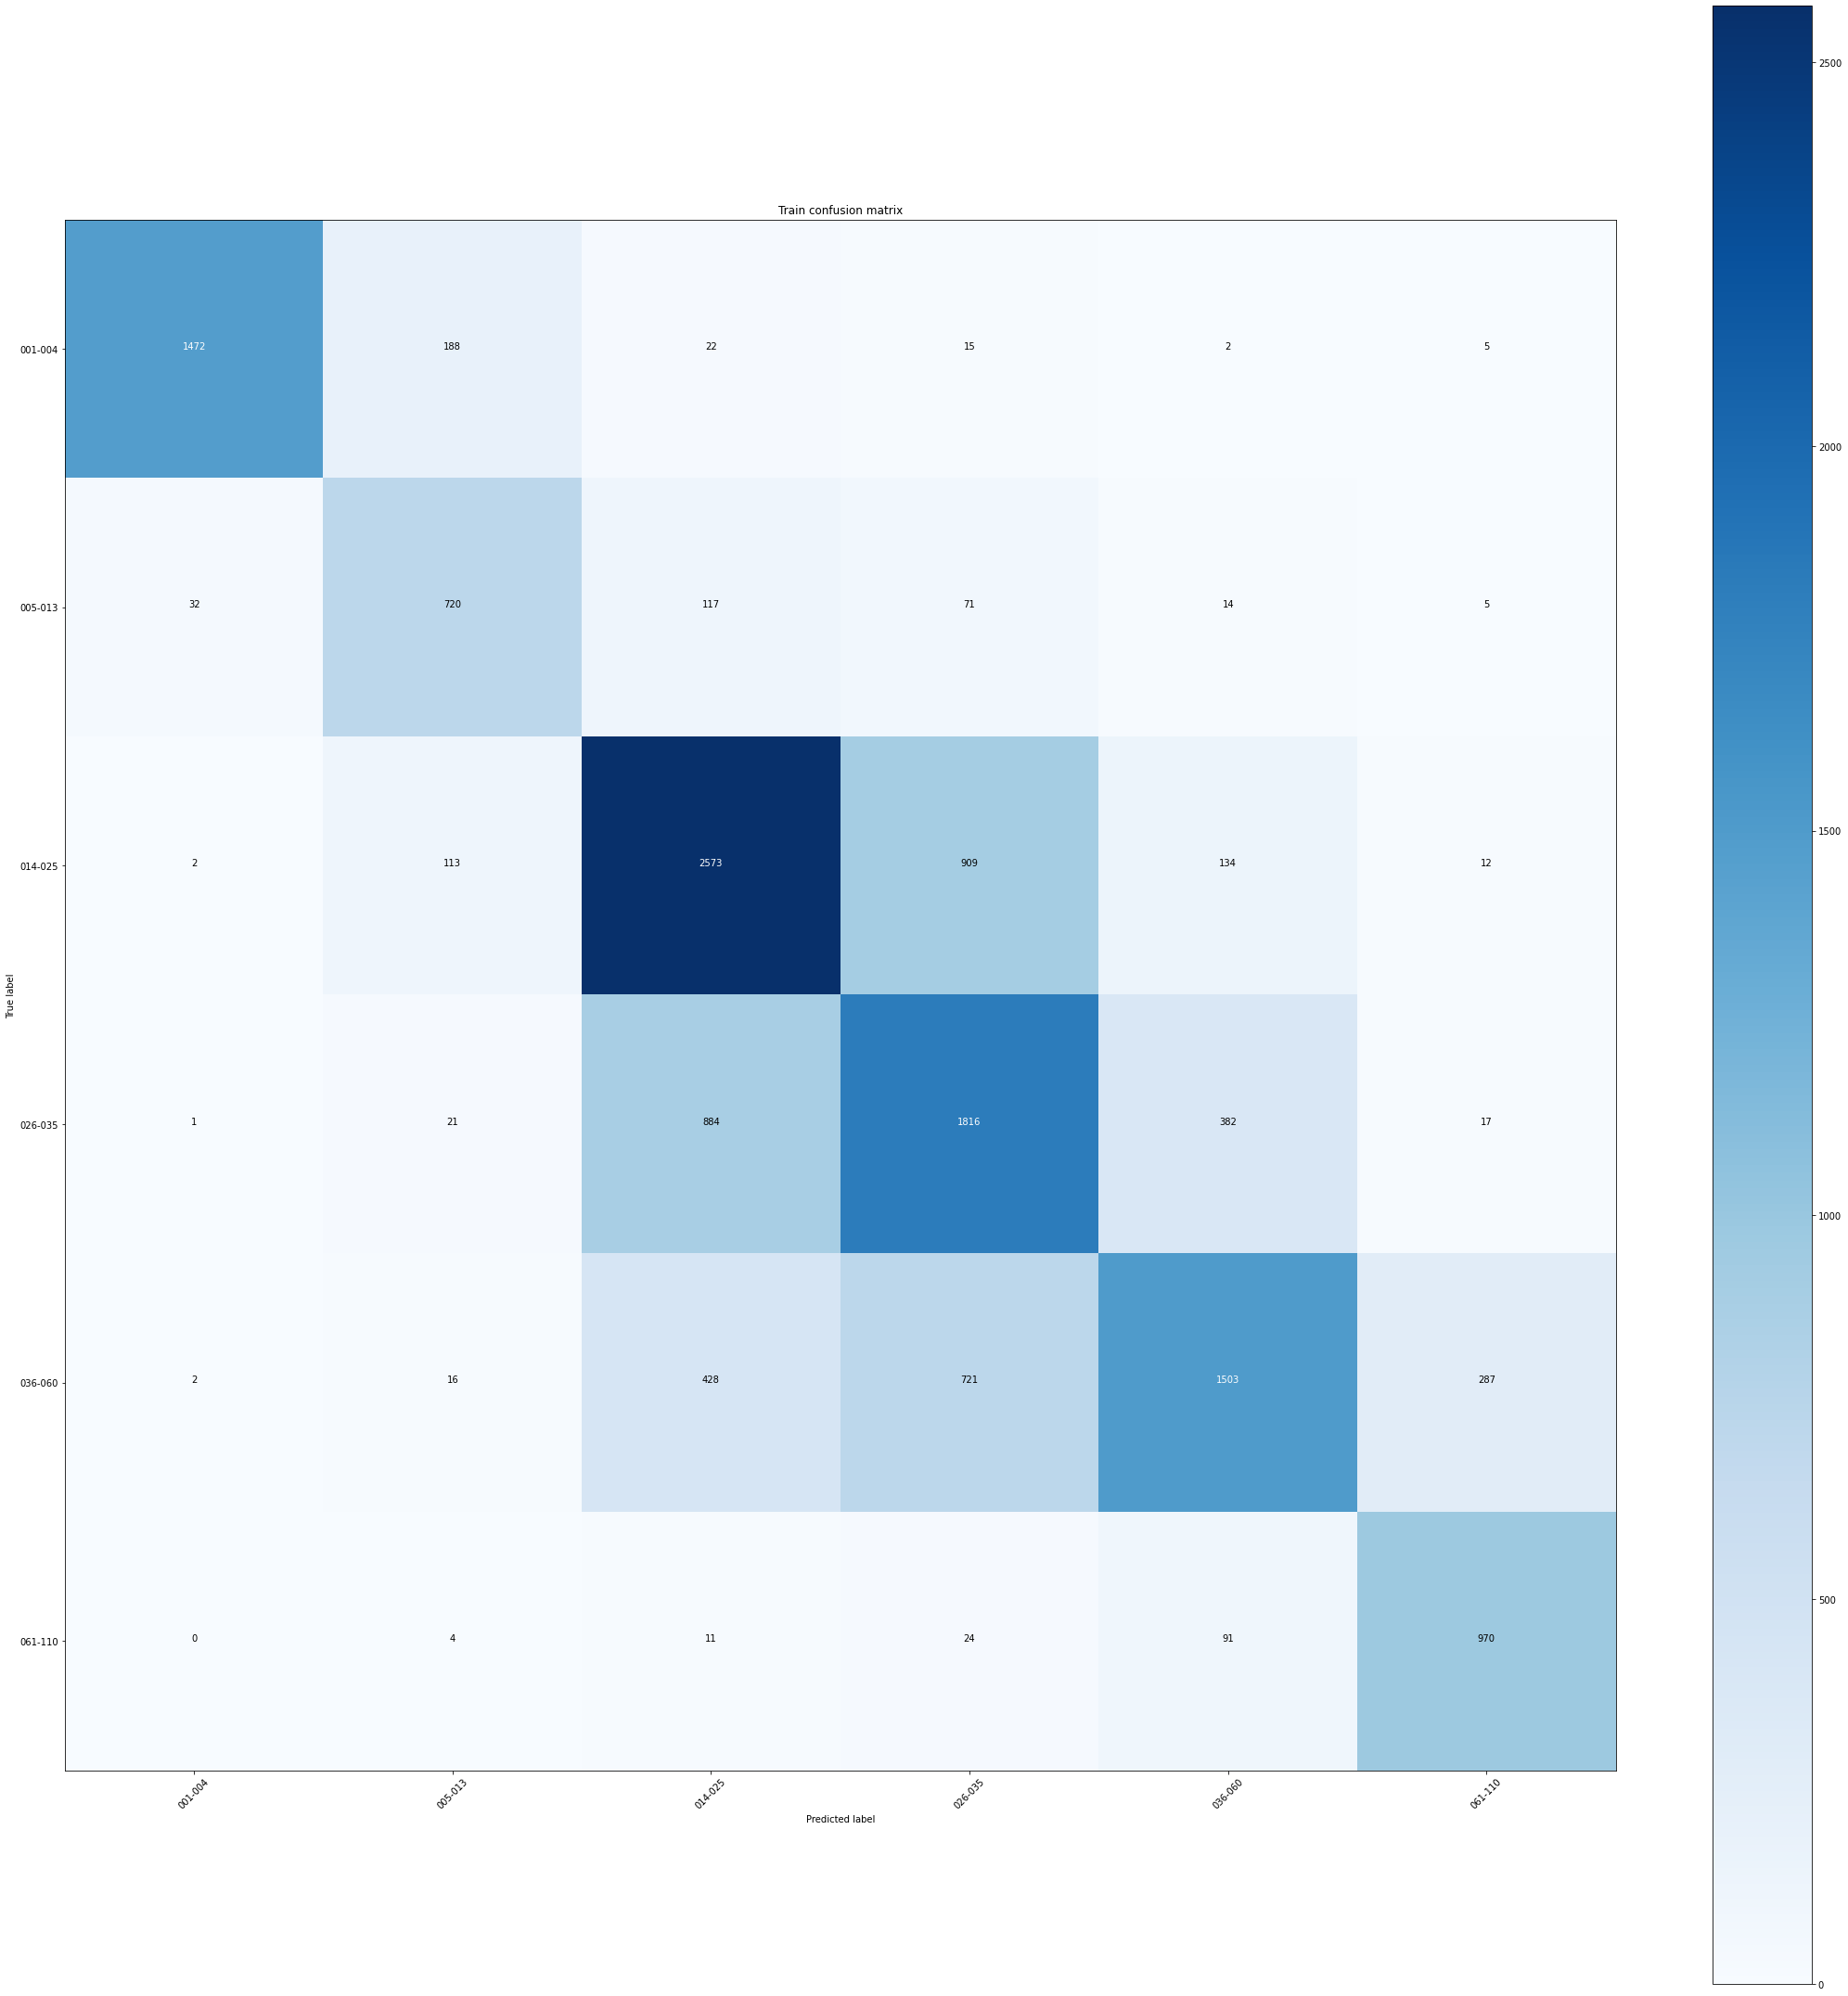

In [30]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')


### Prediction on a New Picture

In [31]:
import requests, io, cv2
import numpy as np
from PIL import Image


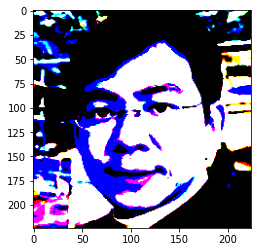

In [39]:
# URL
URL = 'https://cdn.discordapp.com/attachments/1209703582841044992/1249689522657034293/image.png?ex=6668e050&is=66678ed0&hm=c6bcc38e039387e20d5898eaad17ed7770fc0a0e199cd05ccc5134b62977c360&'
response = requests.get(URL)
bytes_im = io.BytesIO(response.content)
cv_im = np.array(Image.open(bytes_im))

if len(cv_im.shape) == 2:
    cv_im = cv2.cvtColor(cv_im, cv2.COLOR_GRAY2RGB)
elif cv_im.shape[2] == 4:
    cv_im = cv2.cvtColor(cv_im, cv2.COLOR_RGBA2RGB)

# Resize
internal_image = cv2.resize(cv_im, (IMAGE_SIZE[0], IMAGE_SIZE[1]))

# Reshape
internal_image = internal_image.reshape(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# Add preprocess
internal_image = preprocess_input(internal_image)

# Plot image
plt.imshow(internal_image[0])
plt.show()

In [40]:
p = model.predict(internal_image)
#p = np.argmax(p)
pred_list = {x : float(y) for x,y in zip(labels, p[0])}
pred_list = dict(sorted(pred_list.items(), reverse=True, key=lambda item: item[1]))
pred_list

{'014-025': 0.5981384515762329,
 '026-035': 0.40135374665260315,
 '036-060': 0.0005077237728983164,
 '005-013': 1.3459677816740623e-08,
 '061-110': 3.1830859128481667e-21,
 '001-004': 2.872462445951839e-31}